# Method development for geometric functions pt 3: $\beta$ aligned-frame (AF) parameters with geometric functions.

- 09/06/20 v1

Aims:

- Develop $\beta_{L,M}$ formalism for AF, using geometric tensor formalism as already applied to MF case.
- Develop corresponding numerical methods - see [pt 1 notebook](https://epsproc.readthedocs.io/en/dev/methods/geometric_method_dev_260220_tidy_160320.html).
- Analyse geometric terms - see [pt 1 notebook](https://epsproc.readthedocs.io/en/dev/methods/geometric_method_dev_260220_tidy_160320.html).

## $\beta_{L,M}^{AF}$ rewrite

The various terms defined in pt 1 can be used to redefine the full AF observables, expressed as a set of $\beta_{L,M}$ coefficients (with the addition of another tensor to define the alignment terms).

The original (full) form for the AF equations, as [implemented in `ePSproc.afblm`](https://epsproc.readthedocs.io/en/dev/modules/epsproc.AFBLM.html) (note, however, that the previous implementation is not fully tested, since it was s...l...o...w... the geometric version should avoid this issue):

\begin{eqnarray}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & = & \sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{M}(-1)^{m}(-1)^{(\mu'-\mu_{0})}\left(\frac{(2l+1)(2l'+1)(2L+1)}{4\pi}\right)^{1/2}\left(\begin{array}{ccc}
l & l' & L\\
0 & 0 & 0
\end{array}\right)\left(\begin{array}{ccc}
l & l' & L\\
-m & m' & -M
\end{array}\right)\nonumber \\
 & \times & I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)\\
 & \times & \sum_{P,R,R'}(2P+1)(-1)^{(R'-R)}\left(\begin{array}{ccc}
1 & 1 & P\\
\mu_{0} & -\mu_{0} & R
\end{array}\right)\left(\begin{array}{ccc}
1 & 1 & P\\
\mu & -\mu' & R'
\end{array}\right)\\
 & \times & \sum_{K,Q,S}(2K+1)^{1/2}(-1)^{K+Q}\left(\begin{array}{ccc}
P & K & L\\
R & -Q & -M
\end{array}\right)\left(\begin{array}{ccc}
P & K & L\\
R' & -S & S-R'
\end{array}\right)A_{Q,S}^{K}(t)
\end{eqnarray}

Where $I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)$ are the energy-dependent dipole matrix elements, and $A_{Q,S}^{K}(t)$ define the alignment parameters.

In terms of the geometric parameters, this can be rewritten as:

\begin{eqnarray}
\beta_{L,-M}^{\mu_{i},\mu_{f}} & =(-1)^{M} & \sum_{P,R',R}{[P]^{\frac{1}{2}}}{E_{P-R}(\hat{e};\mu_{0})}\sum_{l,m,\mu}\sum_{l',m',\mu'}(-1)^{(\mu'-\mu_{0})}{\Lambda_{R'}(\mu,P,R')B_{L,-M}(l,l',m,m')}I_{l,m,\mu}^{p_{i}\mu_{i},p_{f}\mu_{f}}(E)I_{l',m',\mu'}^{p_{i}\mu_{i},p_{f}\mu_{f}*}(E)\sum_{K,Q,S}\Delta_{L,M}(K,Q,S)A_{Q,S}^{K}(t)\label{eq:BLM-tidy-prod-2}
\end{eqnarray}

Where there's a new alignment tensor:

\begin{equation}
\Delta_{L,M}(K,Q,S)=(2K+1)^{1/2}(-1)^{K+Q}\left(\begin{array}{ccc}
P & K & L\\
R & -Q & -M
\end{array}\right)\left(\begin{array}{ccc}
P & K & L\\
R' & -S & S-R'
\end{array}\right)
\end{equation}

And the the $\Lambda_{R',R}$ term is a simplified form of the previously derived MF term:

\begin{equation}
\Lambda_{R'}=(-1)^{(R')}\left(\begin{array}{ccc}
1 & 1 & P\\
\mu & -\mu' & R'
\end{array}\right)\equiv\Lambda_{R',R'}(R_{\hat{n}}=0)
\end{equation} 

All phase conventions should be as the MF case, and the numerics for all the ternsors can be used as is... hopefully...


### To consider

- Normalisation for ADMs? Will matter in cases where abs cross-sections are valid (but not for PADs generally).

## Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc or time
# https://github.com/hector-sab/ttictoc
from ttictoc import TicToc
import time

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

* pyevtk not found, VTK export not available. 


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Alignment terms

### Axis distribution moments

These are already set up by setADMs().

In [3]:
# set default alignment terms - single term A(0,0,0)=1, which corresponds to isotropic distributions
AKQS = ep.setADMs()

AKQS

<xarray.DataArray (ADM: 1, t: 1)>
array([[1]])
Coordinates:
  * ADM      (ADM) MultiIndex
  - K        (ADM) int64 0
  - Q        (ADM) int64 0
  - S        (ADM) int64 0
  * t        (t) int32 0
Attributes:
    dataType:  ADM

In [4]:
AKQSpd,_ = ep.util.multiDimXrToPD(AKQS, colDims='t', squeeze=False)
AKQSpd

,,t,0
K,Q,S,
0,0,0,1


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


,,t,0
K,Q,S,
0,0,0,1.0


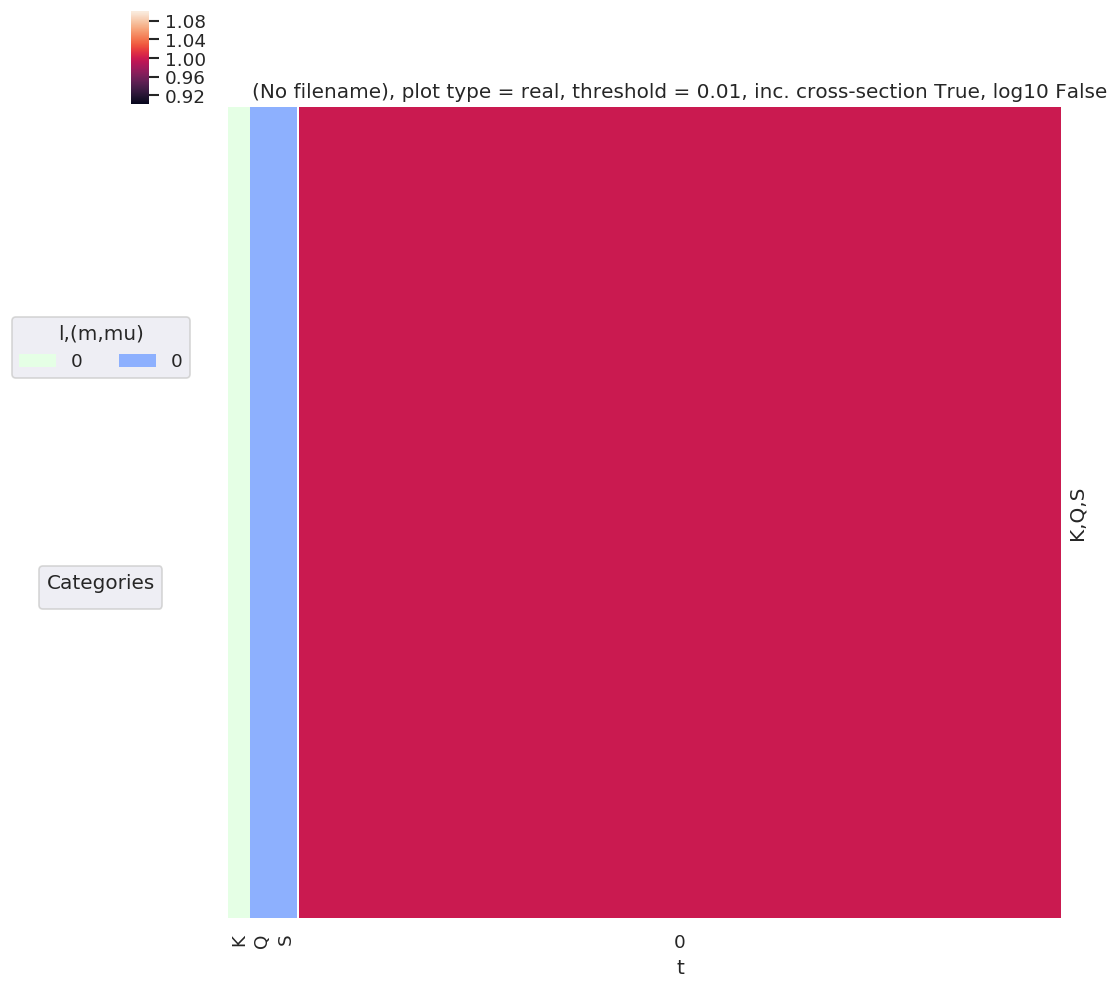

In [5]:
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(AKQS, xDim = 't', pType = 'r', squeeze = False)  # Note squeeze = False required for 1D case (should add this to code!)
daPlotpd

No handles with labels found to put in legend.


Plotting data (No filename), pType=r, thres=0.01, with Seaborn


,,t,0,1
K,Q,S,,
0,0,0,1.0,1.0


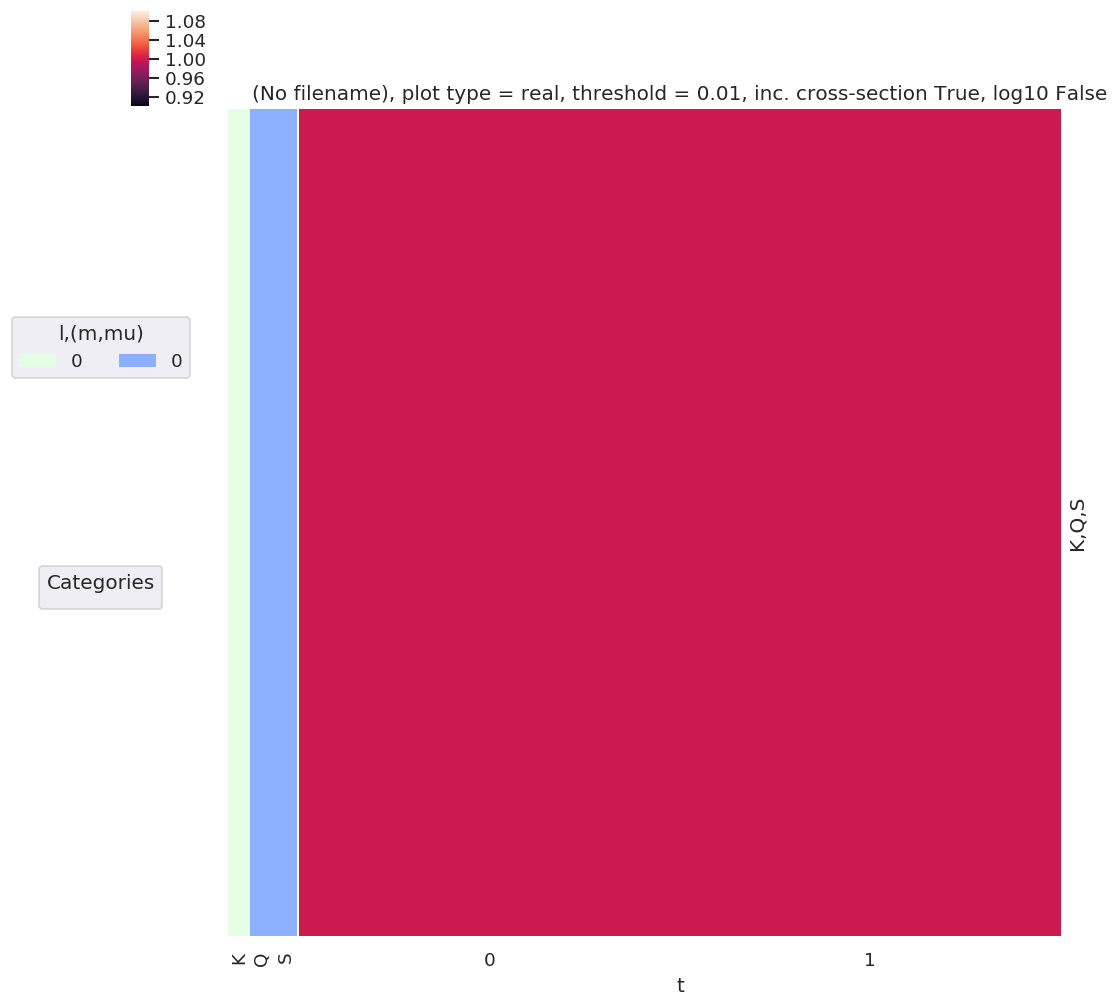

In [6]:
# Test multiple t points
AKQS = ep.setADMs(ADMs = [0,0,0,1,1], t=[0,1])
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(AKQS, xDim = 't', pType = 'r', squeeze = False)  # Note squeeze = False required for 1D case (should add this to code!)
daPlotpd

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


,,t,0,1
K,Q,S,,
0,0,0,1.0,1.0
2,0,0,NaN,0.5


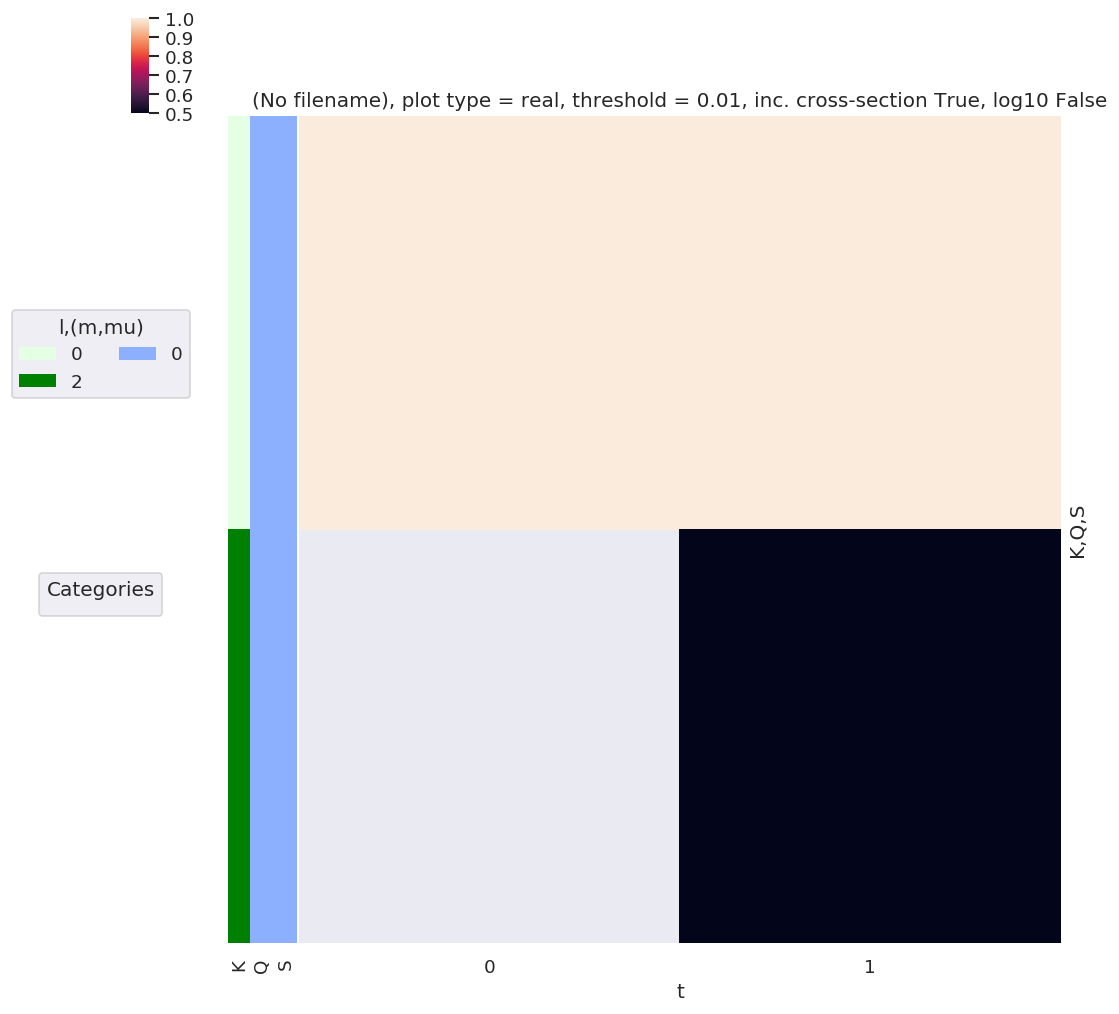

In [7]:
# Test additional time-dependent values
AKQS = ep.setADMs(ADMs = [[0,0,0,1,1],[2,0,0,0,0.5]], t=[0,1])    # Nested list or np.array OK.
# AKQS = ep.setADMs(ADMs = np.array([[0,0,0,1,1],[2,0,0,0,0.5]]), t=[0,1])
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(AKQS, xDim = 't', pType = 'r', squeeze = False)  # Note squeeze = False required for 1D case (should add this to code!)
daPlotpd

### Alignment tensor

As previously defined: 

\begin{equation}
\Delta_{L,M}(K,Q,S)=(2K+1)^{1/2}(-1)^{K+Q}\left(\begin{array}{ccc}
P & K & L\\
R & -Q & -M
\end{array}\right)\left(\begin{array}{ccc}
P & K & L\\
R' & -S & S-R'
\end{array}\right)
\end{equation}

#### Function dev
Based on existing MF functions, see ep.geomFunc.geomCalc and ep.geomFunc.mfblmGeom.

Most similar to existing betaTerm() function, which also has product of 3j terms in a similar manner.

In [8]:
# Generate QNs - code adapted from ep.geomFunc.geomUtils.genllL(Lmin = 0, Lmax = 10, mFlag = True):

# Generate QNs for deltaKQS term - 3j product term
def genKQSterms(Kmin = 0, Kmax = 2, mFlag = True):
    # Set QNs for calculation, (l,m,mp)
    QNs = []
    for P in np.arange(0, 2+1):    # HARD-CODED R for testing - should get from EPR tensor defn. in full calcs.
        for K in np.arange(Kmin, Kmax+1):  # Eventually this will come from alignment term
            for L in np.arange(np.abs(P-K), P+K+1):  # Allowed L given P and K defined
            
                if mFlag:    # Include "m" (or equivalent) terms?
                    mMax = L
                    RMax = P
                    QMax = K
                else:
                    mMax = 0
                    RMax = 0
                    QMax = 0

                for R in np.arange(-RMax, RMax+1):
                    for Q in np.arange(-QMax, QMax+1):
                        #for M in np.arange(np.abs(l-lp), l+lp+1):
#                         for M in np.arange(-mMax, mMax+1):
                            # Set M - note this implies specific phase choice.
                            # M = -(m+mp)
                            # M = (-m+mp)
                            # if np.abs(M) <= L:  # Skip terms with invalid M
                            #     QNs.append([l, lp, L, m, mp, M])

                        # Run for all possible M
                        for M in np.arange(-L, L+1):
                            QNs.append([P, K, L, R, Q, M])

    return np.array(QNs)


# Generate QNs from EPR + AKQS tensors
def genKQStermsFromTensors(EPR, AKQS, uniqueFlag = True, phaseConvention = 'S'):
    '''
    Generate all QNs for :math:`\Delta_{L,M}(K,Q,S)` from existing tensors (Xarrays) :math:`E_{P,R}` and :math:`A^K_{Q,S}`.
    
    Cf. :py:func:`epsproc.geomFunc.genllpMatE`, code adapted from there.
    
    Parameters
    ----------
    matE : Xarray
        Xarray containing matrix elements, with QNs (l,m), as created by :py:func:`readMatEle`

    uniqueFlag : bool, default = True
        Check for duplicates and remove (can occur with some forms of matrix elements).

    mFlag : bool, optional, default = True
        m, mp take all passed values if mFlag=True, or =0 only if mFlag=False

    phaseConvention : optional, str, default = 'S'
        Set phase conventions with :py:func:`epsproc.geomCalc.setPhaseConventions`.
        To use preset phase conventions, pass existing dictionary.
        If matE.attrs['phaseCons'] is already set, this will be used instead of passed args.


    Returns
    -------
    QNs1, QNs2 : two 2D np.arrays
        Values take all allowed combinations ['P','K','L','R','Q','M'] and ['P','K','L','Rp','S','S-Rp'] from supplied matE.
        Note phase conventions not applied to QN lists as yet.

    To do
    -----
    - Implement output options (see dev. function w3jTable).
    
    '''
    
    # Local import.
    from epsproc.geomFunc.geomCalc import setPhaseConventions

    # For transparency/consistency with subfunctions, str/dict now set in setPhaseConventions()
    if 'phaseCons' in EPR.attrs.keys():
        phaseCons = EPR.attrs['phaseCons']
    else:
        phaseCons = setPhaseConventions(phaseConvention = phaseConvention)

    # Get QNs from inputs
    KQScoords = AKQS.unstack().coords  # Use unstack here, or np.unique(matE.l), to avoid duplicates
    PRcoords = EPR.unstack().coords
    
    # Use passed (m,mp) values, or run for m=mp=0 only.
#     if mFlag:
#         mList = matE.unstack().m.values
#     else:
#         mList = 0

    # Set QNs for calculation, one set for each 3j term
    QNs1 = []
    QNs2 = []
    for P in PRcoords['P'].values:   # Note dictionary syntax for coords objects
        for K in KQScoords['K'].values:
            for L in np.arange(np.abs(P-K), P+K+1):  # Allowed L given P and K defined
            
#                 if mFlag:    # Include "m" (or equivalent) terms?
#                     mMax = L
#                     RMax = P
#                     QMax = K
#                 else:
#                     mMax = 0
#                     RMax = 0
#                     QMax = 0

                for R in PRcoords['R'].values:
                    for Q in KQScoords['Q'].values:

                        # Set M, with +/- phase convention - TBC MAY BE INCORRECT IN THIS CASE/CONTEXT?
                        # Note that setting phaseCons['afblmCons']['negM']  = phaseCons['genMatEcons']['negm'] is current default case, but doesn't have to be!
                        if phaseCons['genMatEcons']['negm']:
                            M = (-R+Q)  # Case for M -> -M switch
                        else:
                            M = -(R+Q)  # Usual phase convention.
                            
                        QNs1.append([P, K, L, R, Q, M])
                            
                # Set Rp and S - these are essentially independent of R,Q,M, but keep nested for full dim output.
                for Rp in PRcoords['R'].values:
                    for S in KQScoords['S'].values:
                        SRp = S-Rp  # Set final 3j term, S-Rp

                        QNs2.append([P, K, L, Rp, S, SRp])

                            #for M in np.arange(np.abs(l-lp), l+lp+1):
    #                         for M in np.arange(-mMax, mMax+1):
                                # Set M - note this implies specific phase choice.
                                # M = -(m+mp)
                                # M = (-m+mp)
                                # if np.abs(M) <= L:  # Skip terms with invalid M
                                #     QNs.append([l, lp, L, m, mp, M])

                            # Run for all possible M
    #                         for M in np.arange(-L, L+1):
    #                             QNs.append([P, K, L, R, Q, M])


    if uniqueFlag:
        return np.unique(QNs1, axis = 0), np.unique(QNs2, axis = 0)
    else:
        return np.array(QNs1), np.array(QNs2)

In [9]:
test = genKQSterms()
# test.tolist()   # Use tolist() to get full array output (not truncated by np)
test.shape

(1225, 6)

In [10]:
# Can also just use existing fn.
test2 = ep.geomFunc.genllL(Lmax=2)
test2.shape

(1225, 6)

In [11]:
# Also QN list fn - checks and removes duplicates
QNs = ep.geomFunc.genllL(Lmax=2)
test3 = ep.geomFunc.geomUtils.genllLList(QNs, uniqueFlag = True, mFlag = True)

test3.shape

(1225, 6)

#### All QNs

In [12]:
# Then calc 3js.... as per betaTerm
form = 'xdaLM'  # xds
dlist1 = ['P', 'K', 'L', 'R', 'Q', 'M']
dlist2 = ['P', 'K', 'L', 'Rp', 'S', 'S-Rp']

QNs = ep.geomFunc.genllL(Lmax=2)

In [13]:
# Set phase conventions for this case, extending existing structure
phaseCons = ep.geomFunc.setPhaseConventions('E')

phaseCons['afblmCons'] = {}

# (+/-)M phase selection, set as per existing code, betaCons['negM'] = genMatEcons['negm']       # Use -M term in 3j? Should be anti-correlated with genMatEcons['negm']...? 31/03/20 NOW correlated with mfblmCons['Mphase']
# Note this is correlated with QN generation in genllpMatE() - should set equivalent fn for alignment terms.
# In existing case this arises from M = (-m+mp) or M = -(m+mp) choice.
phaseCons['afblmCons']['negM'] = phaseCons['genMatEcons']['negm']
phaseCons['afblmCons']['negQ'] = True
phaseCons['afblmCons']['negS'] = True




# Apply phase conventions to input QNs
#         if phaseCons['mfblmCons']['BLMmPhase']:
#             QNsBLMtable[:,3] *= -1
#             QNsBLMtable[:,5] *= -1

In [14]:
# Calculate two 3j terms, with respective QN sets
thrj1 = ep.geomFunc.w3jTable(QNs = QNs, nonzeroFlag = True, form = form, dlist = dlist1)
thrj2 = ep.geomFunc.w3jTable(QNs = QNs, nonzeroFlag = True, form = form, dlist = dlist2)

In [15]:
# Multiplication term...

testMult = thrj1.unstack() * thrj2.unstack()

# This can get large quickly - for Kmax=2 already have 2e6 terms

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



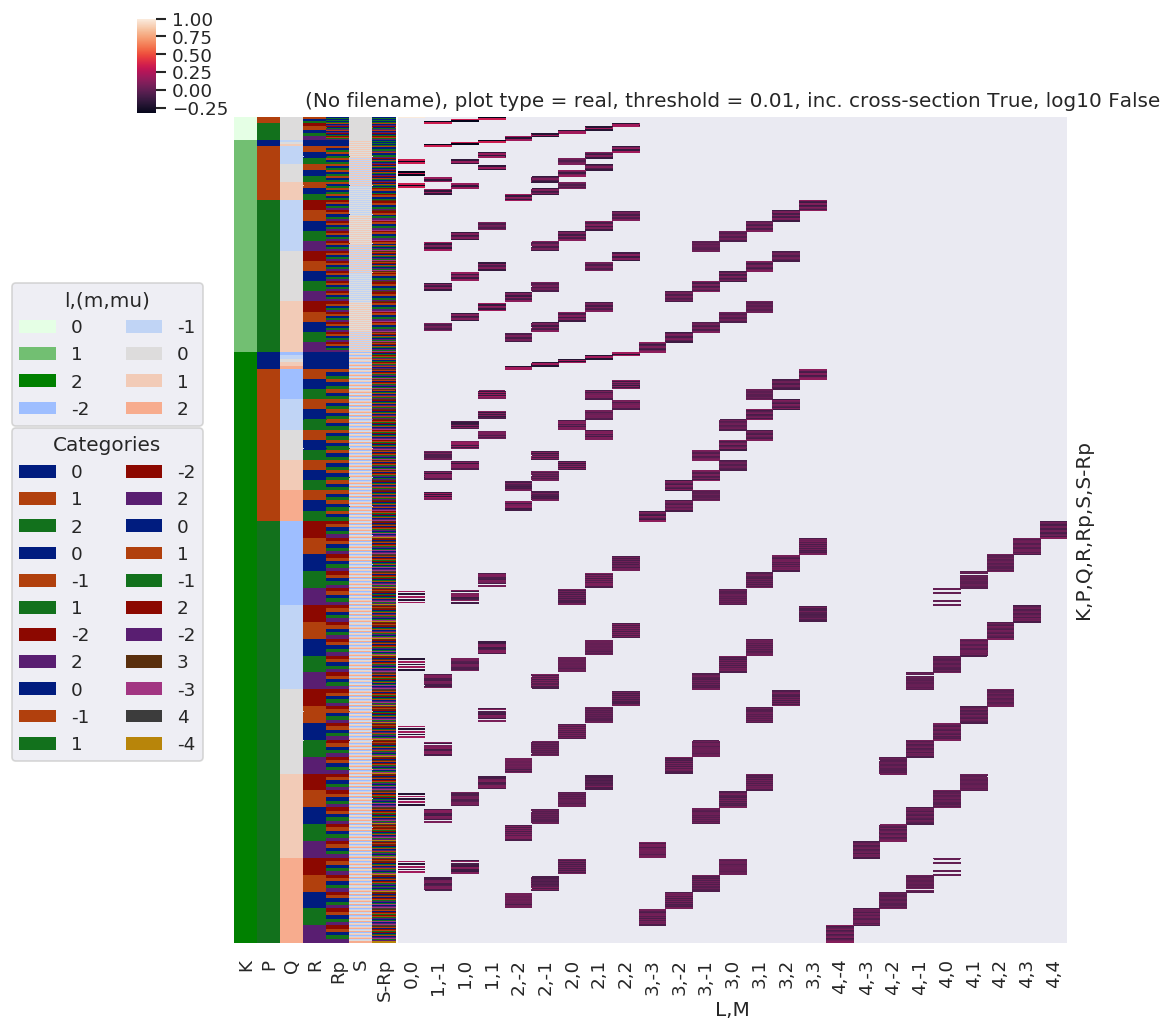

In [16]:
# plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, xDim=xDim, pType = 'r')

#### Reduced QNs set

In [17]:
# Then calc 3js.... as per betaTerm
form = 'xdaLM'  # xds
dlist1 = ['P', 'K', 'L', 'R', 'Q', 'M']
dlist2 = ['P', 'K', 'L', 'Rp', 'S', 'S-Rp']

# Calculate two 3j terms, with respective QN sets
thrj1 = ep.geomFunc.w3jTable(QNs = QNs, nonzeroFlag = True, form = form, dlist = dlist1)
thrj2 = ep.geomFunc.w3jTable(QNs = QNs, nonzeroFlag = True, form = form, dlist = dlist2)

In [18]:
# With subselection (currently don't have QN generation fnc of correct form - see geomUtils)
# from epsproc.util import matEleSelector
# thrj1Sel = ep.util.matEleSelector(thrj1, inds = {'Q':0}, sq=False)

C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


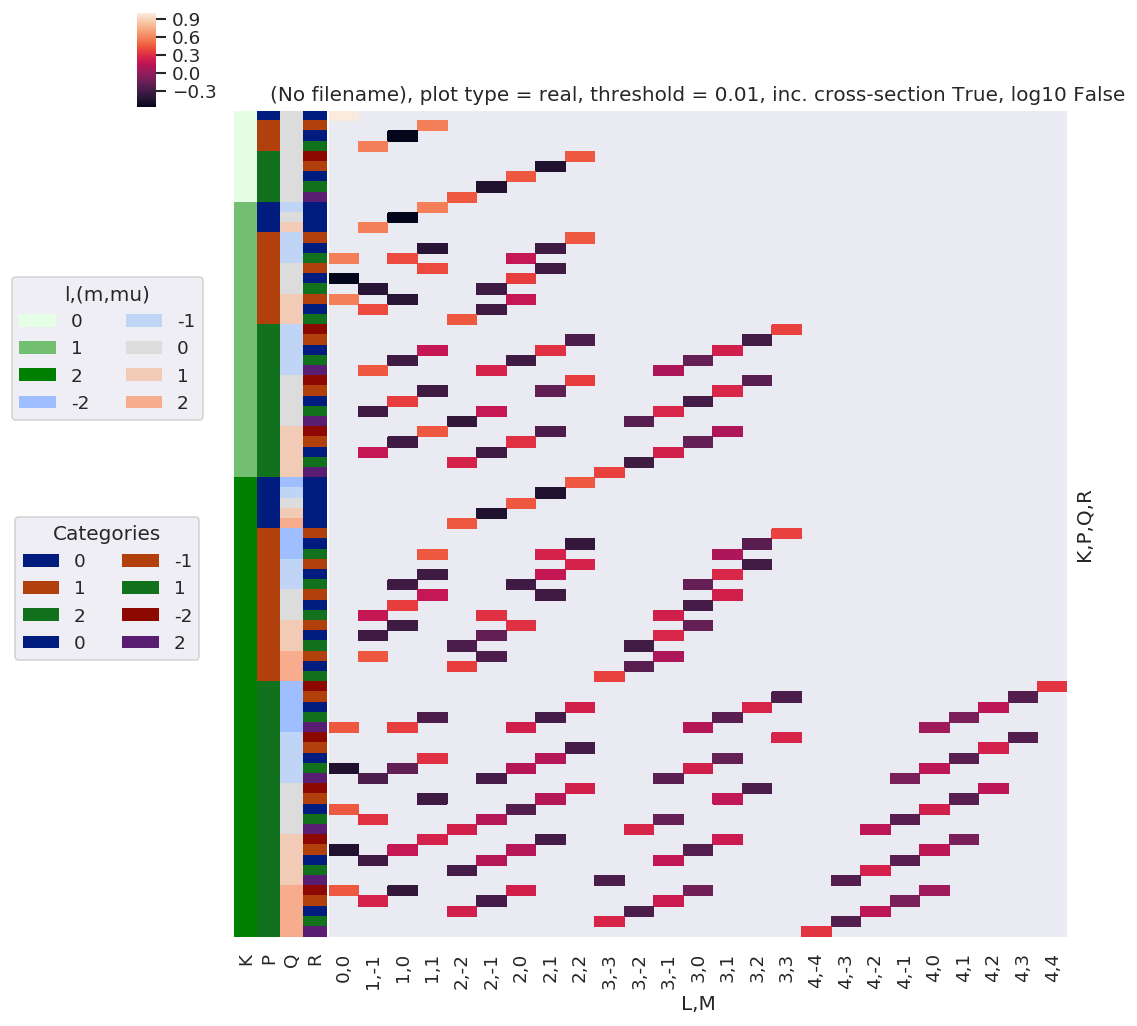

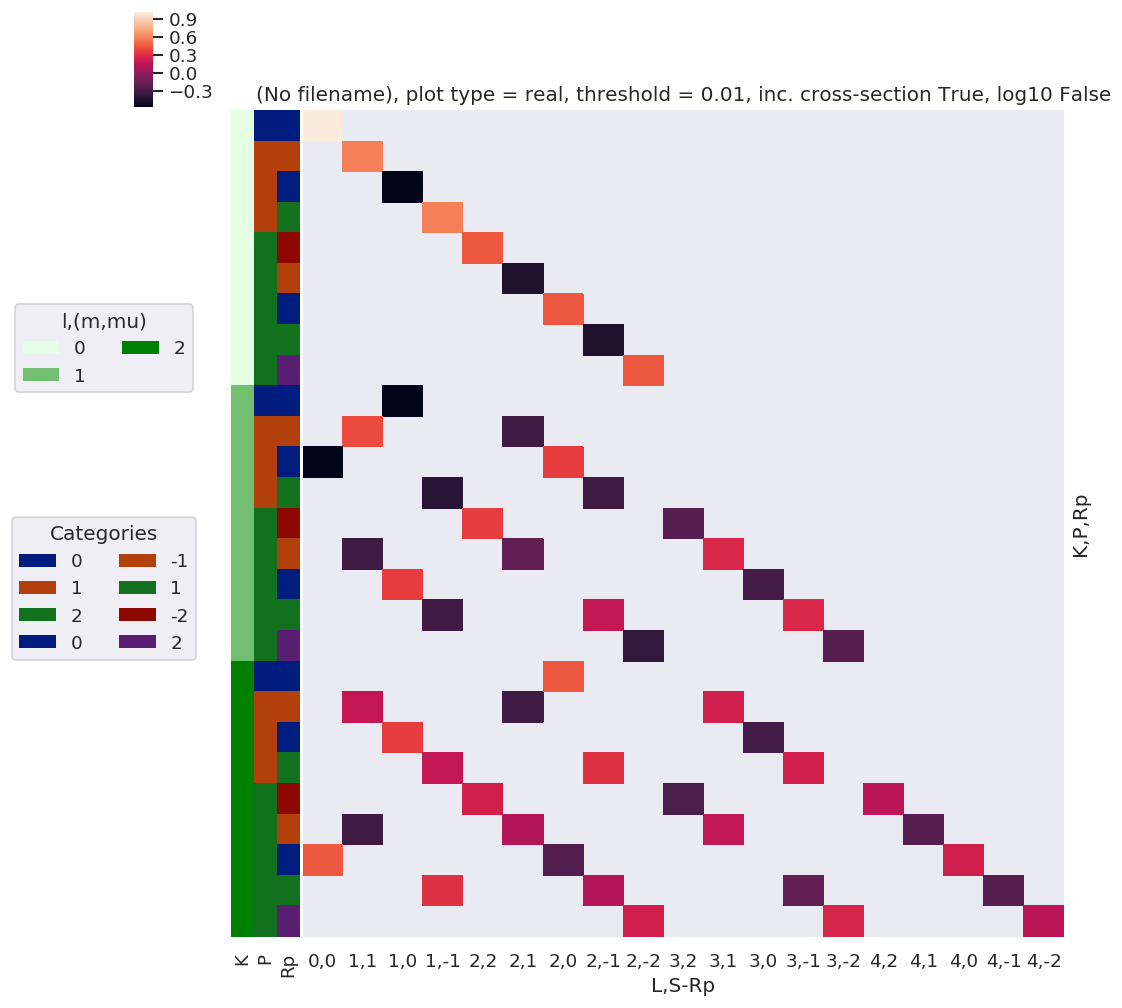

In [19]:
# Check 3j terms
xDim = {'LM':['L','M']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(thrj1, xDim=xDim, pType = 'r')

xDim = {'LM':['L','S-Rp']}
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(thrj2.sel({'S':0}), xDim=xDim, pType = 'r')

In [20]:
# Multiplication term...

testMultSub = thrj1.unstack().sel({'Q':0}) * thrj2.unstack().sel({'S':0})   # SLOW, 91125 elements. ACTUALLY - much faster after a reboot. Sigh.

testMultSub2 = thrj1.sel({'Q':0}).unstack() * thrj2.sel({'S':0}).unstack()  # FAST, 28125 elements. Possible issue with which dims are dropped - check previous notes!

# This can get large quickly - for Kmax=2 already have 2e6 terms

testMultSub.notnull().sum() # == 194 for Kmax = 2, Q=S=0
testMultSub2.notnull().sum() # == 194 for Kmax = 2, Q=S=0  OK

<xarray.DataArray 'w3jStacked' ()>
array(194)
Coordinates:
    Q        int64 0
    S        int64 0

<xarray.DataArray 'w3jStacked' ()>
array(194)

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



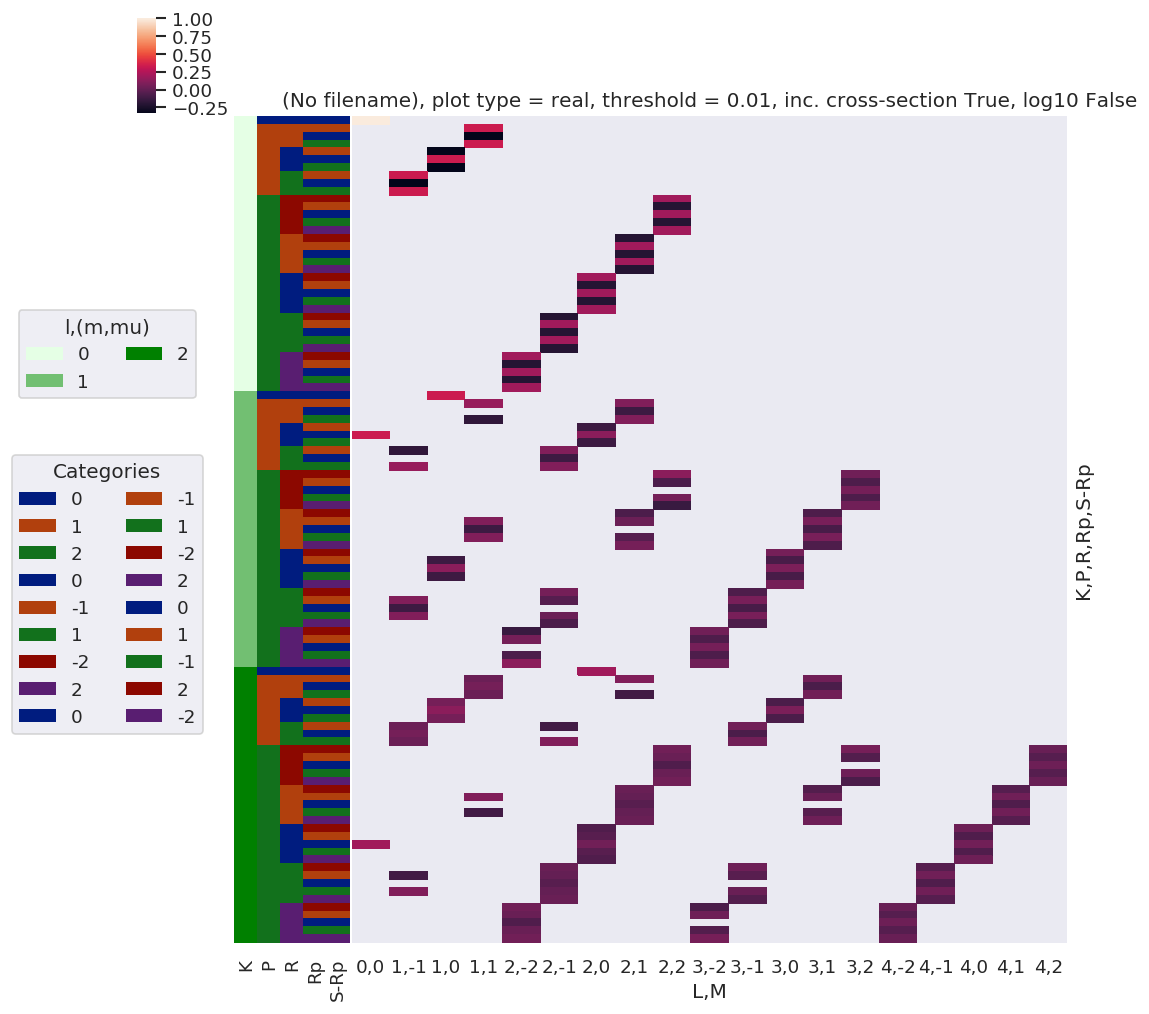

In [21]:
# plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMultSub, xDim=xDim, pType = 'r')

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



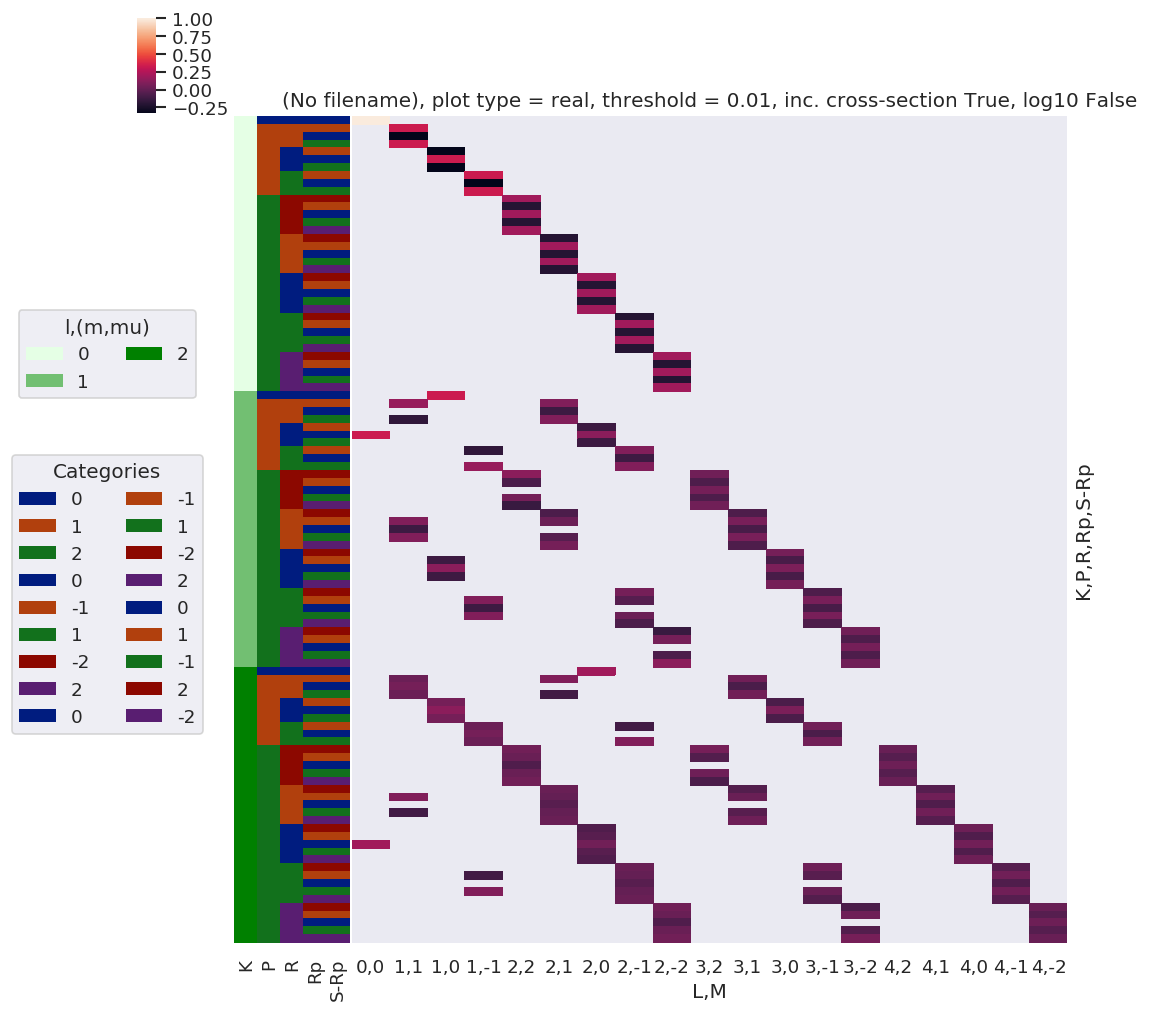

In [22]:
# plotDimsRed = ['l', 'm', 'lp', 'mp']
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMultSub2, xDim=xDim, pType = 'r')

Plots appear to be the same, aside from ordering of M terms(?)

### QNs from existing tensors

In [23]:
phaseConvention = 'E'

# Set polarisation term
p=[0]
EPRX = geomCalc.EPR(form = 'xarray', p = p, nonzeroFlag = True, phaseConvention = phaseConvention).unstack().sel({'R-p':0}).drop('R-p') # Set for R-p = 0 for p=0 case (redundant coord) - need to fix in e-field mult term!
EPRXresort = EPRX.squeeze(['l','lp']).drop(['l','lp'])  # Safe squeeze & drop of selected singleton dims only.

# Set alignment terms (inc. time-dependence)
AKQS = ep.setADMs(ADMs = [[0,0,0,1,1],[2,0,0,0,0.5]], t=[0,1])    # Nested list or np.array OK.

In [24]:
# Calculate alignment term - this cell should form core function, cf. betaTerm() etc.

# Set QNs
QNs1, QNs2 = genKQStermsFromTensors(EPRXresort, AKQS, uniqueFlag = True, phaseConvention = phaseConvention)

# Then calc 3js.... as per betaTerm
form = 'xdaLM'  # xds
dlist1 = ['P', 'K', 'L', 'R', 'Q', 'M']
dlist2 = ['P', 'K', 'L', 'Rp', 'S', 'S-Rp']

# Copy QNs and apply any additional phase conventions
QNs1DeltaTable = QNs1.copy()
QNs2DeltaTable = QNs2.copy()

# Set additional phase cons here - these will be set in master function eventually!
# NOTE - only testing for Q=S=0 case initially.
phaseCons['afblmCons']['negM'] = phaseCons['genMatEcons']['negm']  # IF SET TO TRUE THIS KNOCKS OUT M!=0 terms - not sure if this is correct here, depends also on phase cons in genKQStermsFromTensors().
                                                                    # Yeah, looks like phase error in current case, get terms with R=M, instead of R=-M
                                                                    # Confusion is due to explicit assignment of +/-M terms in QN generation (only allowed terms), which *already* enforces this phase convention.
phaseCons['afblmCons']['negQ'] = True
phaseCons['afblmCons']['negS'] = True

# Switch signs (m,M) before 3j calcs.
if phaseCons['afblmCons']['negQ']:
    QNs1DeltaTable[:,4] *= -1

# Switch sign Q > -Q before 3j calcs.
if phaseCons['afblmCons']['negM']:
    QNs1DeltaTable[:,5] *= -1

# Switch sign S > -S before 3j calcs.
if phaseCons['afblmCons']['negS']:
    QNs2DeltaTable[:,4] *= -1


# Calculate two 3j terms, with respective QN sets
thrj1 = ep.geomFunc.w3jTable(QNs = QNs1DeltaTable, nonzeroFlag = True, form = form, dlist = dlist1)
thrj2 = ep.geomFunc.w3jTable(QNs = QNs2DeltaTable, nonzeroFlag = True, form = form, dlist = dlist2)

# Multiply
thrjMult = thrj1.unstack() * thrj2.unstack()

# Additional terms & multiplications
Kdegen = np.sqrt(2*thrjMult.K + 1)
KQphase = np.power(-1, np.abs(thrjMult.K + thrjMult.Q))

DeltaKQS =  Kdegen * KQphase * thrjMult

# AF term
AFterm = (DeltaKQS * AKQS.unstack()).sum({'K','Q','S'})

In [25]:
thrjMult.notnull().sum() # == 69 for test case with all phase switches on, and same for no phase switches (in test case Q=S=0 in any case!)

<xarray.DataArray 'w3jStacked' ()>
array(69)

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


C:\Users\femtolab\.conda\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



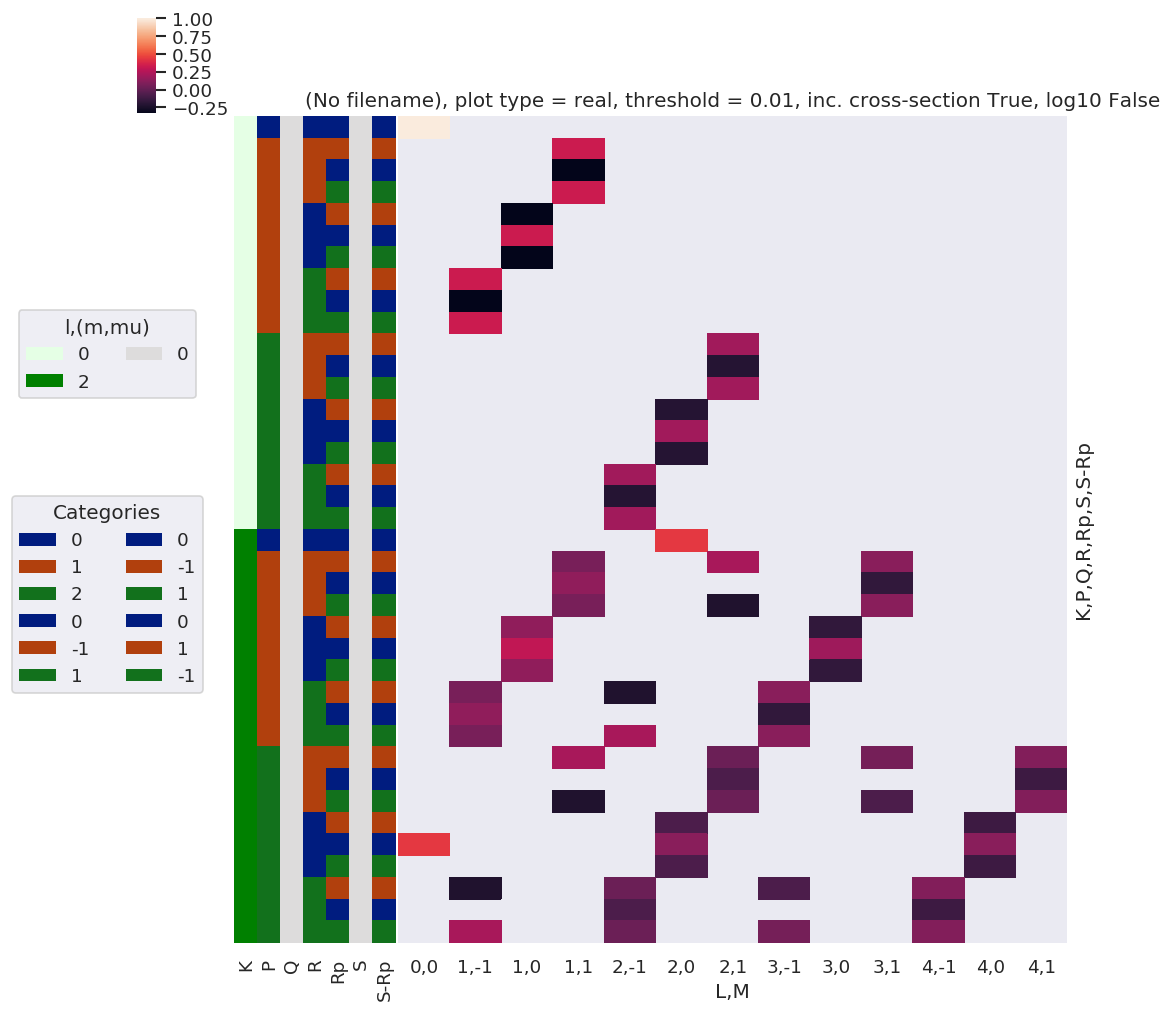

In [26]:
# Plot
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(DeltaKQS, xDim=xDim, pType = 'r')

Set dataType (No dataType)
Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


L                      0         1                             2            \
M                      0        -1         0         1        -1         0   
P R  Rp S-Rp t                                                               
0  0  0  0   0  1.000000       NaN       NaN       NaN       NaN       NaN   
             1  1.000000       NaN       NaN       NaN       NaN  0.223607   
1 -1 -1  1   0       NaN       NaN       NaN  0.333333       NaN       NaN   
             1       NaN       NaN       NaN  0.370601       NaN       NaN   
      0  0   0       NaN       NaN       NaN -0.333333       NaN       NaN   
             1       NaN       NaN       NaN -0.258798       NaN       NaN   
      1 -1   0       NaN       NaN       NaN  0.333333       NaN       NaN   
             1       NaN       NaN       NaN  0.370601       NaN       NaN   
   0 -1  1   0       NaN       NaN -0.333333       NaN       NaN       NaN   
             1       NaN       NaN -0.258798       NaN       NaN       NaN   
      0  0   0       NaN       NaN  0.333333       NaN       NaN       NaN   
             1       NaN       NaN  0.482405       NaN       NaN       NaN   
      1 -1   0       NaN       NaN -0.333333       NaN       NaN       NaN   
             1       NaN       NaN -0.258798       NaN       NaN       NaN   
   1 -1  1   0       NaN  0.333333       NaN       NaN       NaN       NaN   
             1       NaN  0.370601       NaN       NaN -0.111803       NaN   
      0  0   0       NaN -0.333333       NaN       NaN       NaN       NaN   
             1       NaN -0.258798       NaN       NaN       NaN       NaN   
      1 -1   0       NaN  0.333333       NaN       NaN       NaN       NaN   
             1       NaN  0.370601       NaN       NaN  0.111803       NaN   
2 -1 -1  1   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1       NaN       NaN       NaN  0.111803       NaN       NaN   
      0  0   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1       NaN       NaN       NaN       NaN       NaN       NaN   
      1 -1   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1       NaN       NaN       NaN -0.111803       NaN       NaN   
   0 -1  1   0       NaN       NaN       NaN       NaN       NaN -0.200000   
             1       NaN       NaN       NaN       NaN       NaN -0.231944   
      0  0   0       NaN       NaN       NaN       NaN       NaN  0.200000   
             1  0.223607       NaN       NaN       NaN       NaN  0.263888   
      1 -1   0       NaN       NaN       NaN       NaN       NaN -0.200000   
             1       NaN       NaN       NaN       NaN       NaN -0.231944   
   1 -1  1   0       NaN       NaN       NaN       NaN  0.200000       NaN   
             1       NaN -0.111803       NaN       NaN  0.215972       NaN   
      0  0   0       NaN       NaN       NaN       NaN -0.200000       NaN   
             1       NaN       NaN       NaN       NaN -0.231944       NaN   
      1 -1   0       NaN       NaN       NaN       NaN  0.200000       NaN   
             1       NaN  0.111803       NaN       NaN  0.215972       NaN   

L                                3                             4            \
M                      1        -1         0         1        -1         0   
P R  Rp S-Rp t                                                               
0  0  0  0   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1       NaN       NaN       NaN       NaN       NaN       NaN   
1 -1 -1  1   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1  0.111803       NaN       NaN  0.063888       NaN       NaN   
      0  0   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1       NaN       NaN       NaN -0.078246       NaN       NaN   
      1 -1   0       NaN       NaN       NaN       NaN       NaN       NaN   
             1 -0.111

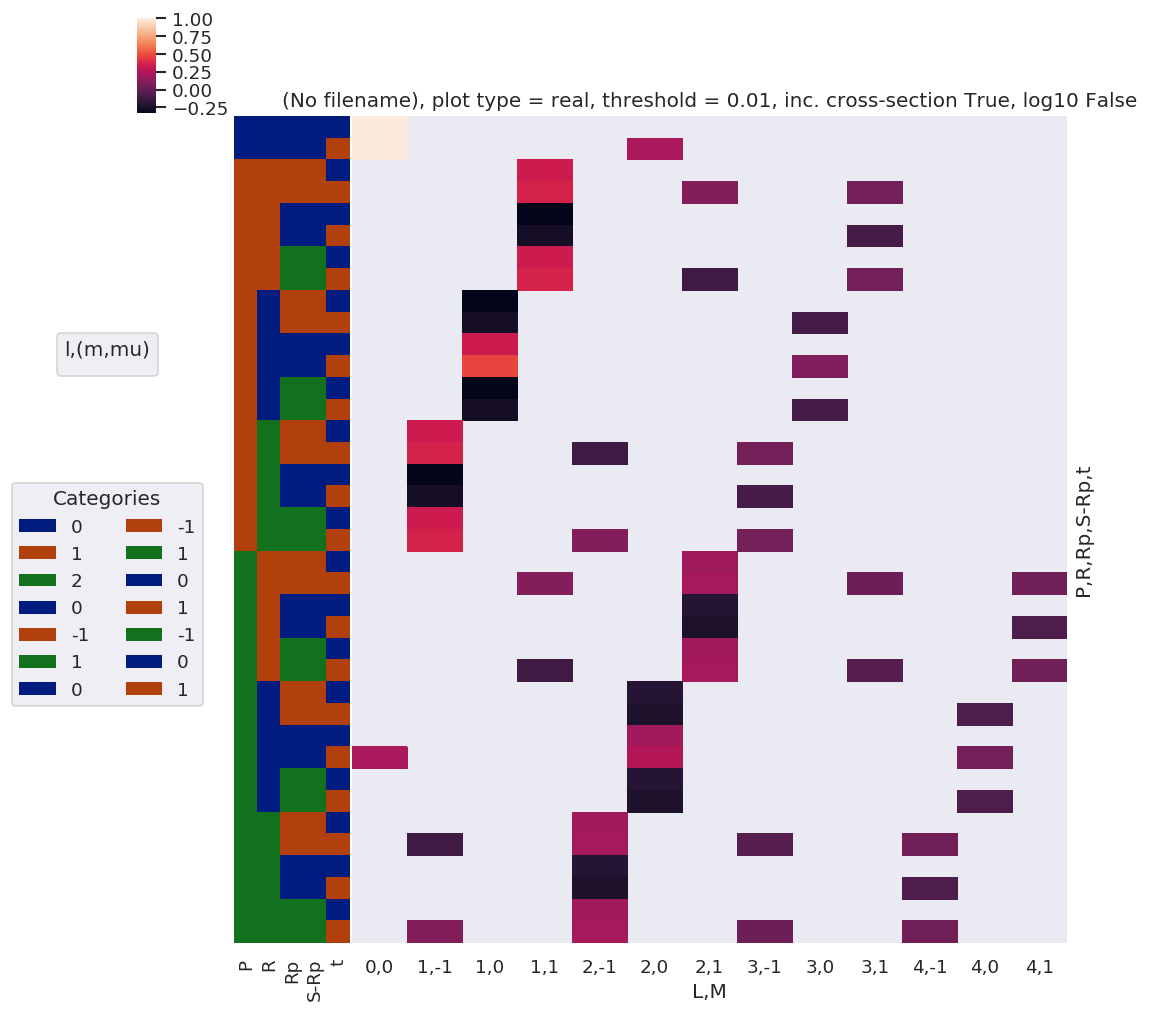

In [27]:
# Plot
xDim = {'LM':['L','M']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(AFterm, xDim=xDim, pType = 'r')
daPlotpd

Note here that there are blocks of non-zero terms with M=+/-1, these should drop out later (?) by sums over symmetry and/or other 3j terms... TBC...

## Lambda term redux

Use existing function and force/sub-select terms...

In [28]:
# Code adapted from mfblmXprod()

eulerAngs = np.array([0,0,0], ndmin=2)
# RX = ep.setPolGeoms(eulerAngs = eulerAngs)   # This throws error in geomCalc.MFproj???? Something to do with form of terms passed to wD, line 970 vs. 976 in geomCalc.py
RX = ep.setPolGeoms()   # (0,0,0) term in geomCalc.MFproj OK.

lambdaTerm, lambdaTable, lambdaD, QNsLambda = geomCalc.MFproj(RX = RX, form = 'xarray', phaseConvention = phaseConvention)
# lambdaTermResort = lambdaTerm.squeeze().drop('l').drop('lp')   # This removes photon (l,lp) dims fully.
lambdaTermResort = lambdaTerm.squeeze(['l','lp']).drop(['l','lp']).sel({'Labels':'z'})  # Safe squeeze & drop of selected singleton dims only.

Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


P                0         1                             2            \
Rp               0        -1         0         1        -2        -1   
R  mu mup                                                              
-2  1  1       NaN       NaN       NaN       NaN  0.447214       NaN   
-1  0  1       NaN -0.408248       NaN       NaN       NaN  0.316228   
    1  0       NaN  0.408248       NaN       NaN       NaN  0.316228   
 0 -1  1   0.57735       NaN -0.408248       NaN       NaN       NaN   
    0  0  -0.57735       NaN       NaN       NaN       NaN       NaN   
    1 -1   0.57735       NaN  0.408248       NaN       NaN       NaN   
 1 -1  0       NaN       NaN       NaN -0.408248       NaN       NaN   
    0 -1       NaN       NaN       NaN  0.408248       NaN       NaN   
 2 -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   

P                                        
Rp                0         1         2  
R  mu mup                                
-2  1  1        NaN       NaN       NaN  
-1  0  1        NaN       NaN       NaN  
    1  0        NaN       NaN       NaN  
 0 -1  1   0.182574       NaN       NaN  
    0  0   0.365148       NaN       NaN  
    1 -1   0.182574       NaN       NaN  
 1 -1  0        NaN  0.316228       NaN  
    0 -1        NaN  0.316228       NaN  
 2 -1 -1        NaN       NaN  0.447214

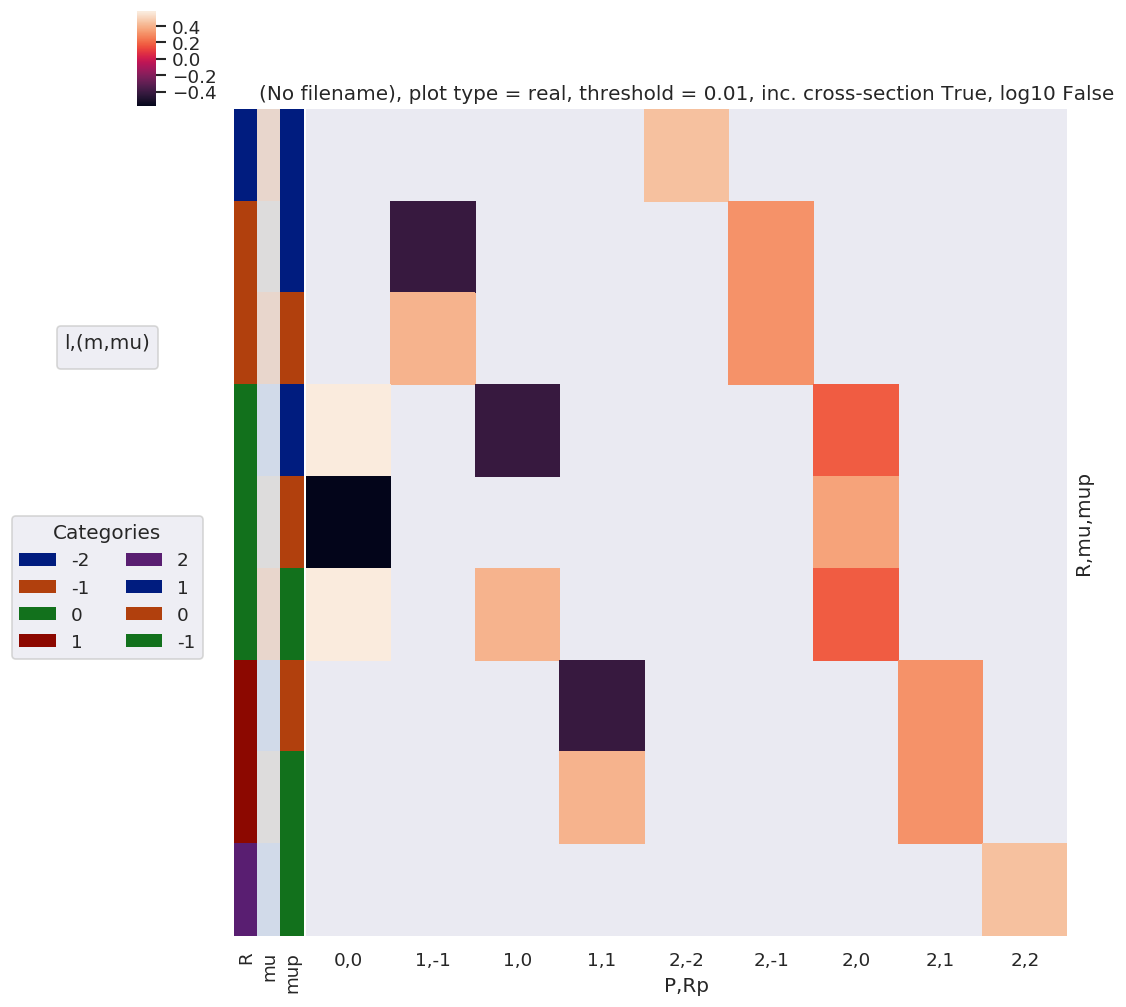

In [29]:
# Plot
xDim = {'PRp':['P','Rp']}
# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(testMult, plotDims=plotDimsRed, xDim=xDim, pType = 'r')
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(lambdaTermResort, xDim=xDim, pType = 'r')
daPlotpd

### Check component terms are as expected

Should have R = Rp for z case, and wD terms = 1 or 0.

In [30]:
lambdaTablepd, _ = ep.util.multiDimXrToPD(lambdaTable, colDims=xDim, dropna=True)
lambdaTablepd

P                     0         1                             2            \
Rp                    0        -1         0         1        -2        -1   
R  l lp mu mup                                                              
-2 1 1  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN       NaN       NaN       NaN       NaN       NaN   
         0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN       NaN       NaN       NaN       NaN -0.316228   
         1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN -0.316228   
            1       NaN       NaN       NaN       NaN  0.447214       NaN   
-1 1 1  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN  0.408248       NaN       NaN   
            1       NaN       NaN -0.408248       NaN       NaN       NaN   
         0 -1       NaN       NaN       NaN -0.408248       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN  0.408248       NaN       NaN       NaN -0.316228   
         1 -1       NaN       NaN  0.408248       NaN       NaN       NaN   
            0       NaN -0.408248       NaN       NaN       NaN -0.316228   
            1       NaN       NaN       NaN       NaN  0.447214       NaN   
 0 1 1  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN  0.408248       NaN       NaN   
            1   0.57735       NaN -0.408248       NaN       NaN       NaN   
         0 -1       NaN       NaN       NaN -0.408248       NaN       NaN   
            0  -0.57735       NaN       NaN       NaN       NaN       NaN   
            1       NaN  0.408248       NaN       NaN       NaN -0.316228   
         1 -1   0.57735       NaN  0.408248       NaN       NaN       NaN   
            0       NaN -0.408248       NaN       NaN       NaN -0.316228   
            1       NaN       NaN       NaN       NaN  0.447214       NaN   
 1 1 1  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN  0.408248       NaN       NaN   
            1       NaN       NaN -0.408248       NaN       NaN       NaN   
         0 -1       NaN       NaN       NaN -0.408248       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN  0.408248       NaN       NaN       NaN -0.316228   
         1 -1       NaN       NaN  0.408248       NaN       NaN       NaN   
            0       NaN -0.408248       NaN       NaN       NaN -0.316228   
            1       NaN       NaN       NaN       NaN  0.447214       NaN   
 2 1 1  -1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN       NaN       NaN       NaN       NaN       NaN   
         0 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN       NaN   
            1       NaN       NaN       NaN       NaN       NaN -0.316228   
         1 -1       NaN       NaN       NaN       NaN       NaN       NaN   
            0       NaN       NaN       NaN       NaN       NaN -0.316228   
            1       NaN       NaN       NaN       NaN  0.447214       NaN   

P                                             
Rp                     0         1         2  
R  l lp mu mup                                
-2 1 1  -1 -1        NaN       NaN  0.447214  
            0        NaN -0.316228       NaN  
            1   0.182574       NaN       NaN  
         0 -1        

In [31]:
lambdaTermResortpd, _ = ep.util.multiDimXrToPD(lambdaTermResort, colDims=xDim, dropna=True)
lambdaTermResortpd

# Think this is as per lambdaTable terms, just different ordering - because lambdaTable doesn't include some phase switches?

P                           0                   1                      \
Rp                          0                  -1                   0   
R  mu mup                                                               
-2 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
    0 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
    1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
-1 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN  0.000000+0.000000j   
    0 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN -0.408248+0.000000j                 NaN   
    1 -1                  NaN                 NaN  0.000000+0.000000j   
       0                  NaN  0.408248+0.000000j                 NaN   
       1                  NaN                 NaN                 NaN   
 0 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1   0.577350+0.000000j                 NaN -0.408248+0.000000j   
    0 -1                  NaN                 NaN                 NaN   
       0  -0.577350+0.000000j                 NaN                 NaN   
       1                  NaN  0.000000+0.000000j                 NaN   
    1 -1   0.577350+0.000000j                 NaN  0.408248+0.000000j   
       0                  NaN  0.000000+0.000000j                 NaN   
       1                  NaN                 NaN                 NaN   
 1 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN  0.000000+0.000000j   
    0 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN  0.000000+0.000000j                 NaN   
    1 -1                  NaN                 NaN  0.000000+0.000000j   
       0                  NaN  0.000000+0.000000j                 NaN   
       1                  NaN                 NaN                 NaN   
 2 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
    0 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
    1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   

P                                               2                      \
Rp                          1                  -2                  -1   
R  mu mup                                                               
-2 -1 -1                  NaN                 NaN                 NaN   
       0                  NaN                 NaN                 NaN   
       1                  NaN                 NaN                 NaN   
    0 -1                  NaN                 NaN        

In [32]:
# wigner D term looks good.
lambdaDpd, _ = ep.util.multiDimXrToPD(lambdaD.sel({'Labels':'z'}), colDims=xDim, dropna=True)
lambdaDpd


P                    0                                          \
Rp                   2                   1                   0   
R                                                                
 2                 NaN                 NaN                 NaN   
 1                 NaN                 NaN                 NaN   
 0  0.000000-0.000000j  0.000000-0.000000j  1.000000-0.000000j   
-1                 NaN                 NaN                 NaN   
-2                 NaN                 NaN                 NaN   

P                                                            1  \
Rp                  -1                  -2                   2   
R                                                                
 2                 NaN                 NaN                 NaN   
 1                 NaN                 NaN  0.000000-0.000000j   
 0  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j   
-1                 NaN                 NaN  0.000000-0.000000j   
-2                 NaN                 NaN                 NaN   

P                                                               \
Rp                   1                   0                  -1   
R                                                                
 2                 NaN                 NaN                 NaN   
 1  1.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j   
 0  0.000000-0.000000j  1.000000-0.000000j  0.000000-0.000000j   
-1  0.000000-0.000000j  0.000000-0.000000j  1.000000+0.000000j   
-2                 NaN                 NaN                 NaN   

P                                        2                      \
Rp                  -2                   2                   1   
R                                                                
 2                 NaN  1.000000-0.000000j  0.000000-0.000000j   
 1  0.000000-0.000000j  0.000000-0.000000j  1.000000-0.000000j   
 0  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j   
-1  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j   
-2                 NaN  0.000000-0.000000j  0.000000-0.000000j   

P                                                               
Rp                   0                  -1                  -2  
R                                                               
 2  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j  
 1  0.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j  
 0  1.000000-0.000000j  0.000000-0.000000j  0.000000-0.000000j  
-1  0.000000-0.000000j  1.000000+0.000000j  0.000000-0.000000j  
-2  0.000000-0.000000j  0.000000-0.000000j  1.000000+0.000000j

## Build full calculation from functions

Use mfblmGeom.py as template: basically just need modified lambda term as above, and new alignment term, and rest of calculation should be identical.

In [33]:
# Check polProd term - incorporate alignment term here...?

# Existing terms
# polProd = (EPRXresort * lambdaTermResort) 

# sumDimsPol = ['P','R','Rp','p']
# polProd = polProd.sum(sumDimsPol)

# Test with alignment term
polProd = (EPRXresort * lambdaTermResort * AFterm) 
sumDimsPol = ['P','R','Rp','p', 'S-Rp']
polProd = polProd.sum(sumDimsPol)
# Looks OK - keeps correct dims in test case! 270 terms.

**NOW implemented in ep.geomFunc.afblmGeom.py**

## Testing...
16/06/20

Test code adapted from previous round of AF tests, http://localhost:8888/lab/tree/dev/ePSproc/ePSproc_AFBLM_calcs_bench_100220.ipynb

See also MFBLM test code, http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_2020/geometric_method_dev_pt2_170320_v090620.ipynb

### Load data

In [34]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
dataSet = ep.readMatEle(fileIn = dataFile)
dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 3 CrossSection segments.
Found 3 CrossSection segments (sets of results).
Processed 3 sets of Cro

### Plot ePS results (isotropic case)

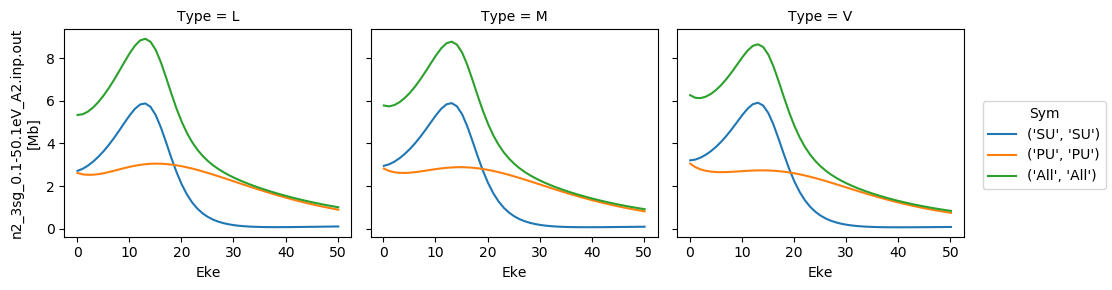

In [35]:
# Plot cross sections using Xarray functionality
# Set here to plot per file - should add some logic to combine files.
for data in dataXS:
    daPlot = data.sel(XC='SIGMA')
    daPlot.plot.line(x='Eke', col='Type')

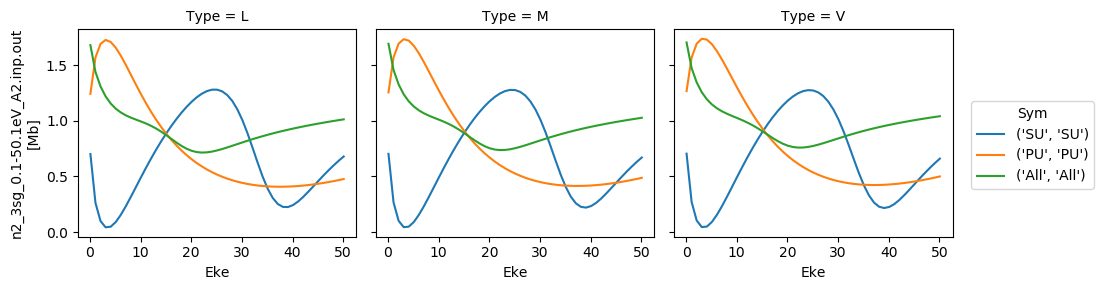

In [36]:
# Repeat for betas
for data in dataXS:
    daPlot = data.sel(XC='BETA')
    daPlot.plot.line(x='Eke', col='Type')

### Try new AF calculation - isotropic (default) case

Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


Eke                          0.1        1.1       2.1       3.1       4.1   \
Cont Targ Total l m  mu                                                      
PU   SG   PU    1 -1  1 -6.203556   7.496908  3.926892  1.071093 -0.335132   
                   1 -1 -6.203556   7.496908  3.926892  1.071093 -0.335132   
                3 -1  1 -2.090641  -1.723467 -3.571018 -1.703191  0.232612   
                   1 -1 -2.090641  -1.723467 -3.571018 -1.703191  0.232612   
                5 -1  1  0.000000   0.013246  0.000000 -0.013096 -0.024367   
                   1 -1  0.000000   0.013246  0.000000 -0.013096 -0.024367   
                7 -1  1  0.000000   0.000000  0.000000  0.000000  0.000000   
                   1 -1  0.000000   0.000000  0.000000  0.000000  0.000000   
SU   SG   SU    1  0  0  6.246520 -10.081763 -8.912214 -5.342049 -3.160539   
                3  0  0  2.605768   2.775108  4.733473  1.677812 -1.450830   
                5  0  0  0.000000  -0.020864  0.000000  0.024263  0.042694   
                7  0  0  0.000000   0.000000  0.000000  0.000000  0.000000   

Eke                          5.1       6.1       7.1        8.1        9.1   \
Cont Targ Total l m  mu                                                       
PU   SG   PU    1 -1  1 -1.043391 -1.396885 -1.554984  -1.598812  -1.573327   
                   1 -1 -1.043391 -1.396885 -1.554984  -1.598812  -1.573327   
                3 -1  1  1.862713  3.201022  4.298839   5.198215   5.929303   
                   1 -1  1.862713  3.201022  4.298839   5.198215   5.929303   
                5 -1  1 -0.033455 -0.042762 -0.053765  -0.067354  -0.083946   
                   1 -1 -0.033455 -0.042762 -0.053765  -0.067354  -0.083946   
                7 -1  1  0.000000  0.000000  0.000000   0.000000   0.000000   
                   1 -1  0.000000  0.000000  0.000000   0.000000   0.000000   
SU   SG   SU    1  0  0 -1.795783 -0.867993 -0.174154   0.400643   0.926420   
                3  0  0 -4.187395 -6.554491 -8.601759 -10.343109 -11.747922   
                5  0  0  0.059142  0.077308  0.099330   0.126227   0.157745   
                7  0  0  0.000000  0.000000  0.000000   0.000000   0.000000   

Eke                      ...      41.1      42.1      43.1      44.1  \
Cont Targ Total l m  mu  ...                                           
PU   SG   PU    1 -1  1  ... -0.396306 -0.422225 -0.448003 -0.473466   
                   1 -1  ... -0.396306 -0.422225 -0.448003 -0.473466   
                3 -1  1  ...  1.200463  1.040074  0.892501  0.757189   
                   1 -1  ...  1.200463  1.040074  0.892501  0.757189   
                5 -1  1  ... -0.325544 -0.318791 -0.312332 -0.306211   
                   1 -1  ... -0.325544 -0.318791 -0.312332 -0.306211   
                7 -1  1  ...  0.027469  0.028083  0.028678  0.029257   
                   1 -1  ...  0.027469  0.028083  0.028678  0.029257   
SU   SG   SU    1  0  0  ... -0.854886 -0.940017 -1.021577 -1.099776   
                3  0  0  ... -0.293053 -0.441416 -0.579578 -0.708075   
                5  0  0  ...  0.490499  0.511546  0.531810  0.551281   
                7  0  0  ... -0.039566 -0.041422 -0.043265 -0.045092   

Eke                          45.1      46.1      47.1      48.1      49.1  \
Cont Targ Total l m  mu                                                     
PU   SG   PU    1 -1  1 -0.498463 -0.522867 -0.546573 -0.569493 -0.591558   
                   1 -1 -0.498463 -0.522867 -0.546573 -0.569493 -0.591558   
                3 -1  1  0.633556  0.521004  0.418928  0.326726  0.243800   
                   1 -1  0.633556  0.521004  0.418928  0.326726  0.243800   
                5 -1  1 -0.300456 -0.295091 -0.290130 -0.285584 -0.281453   
                   1 -1 -0.300456 -0.295091 -0.290130 -0.285584 -0.281453   
                7 -1  1  0.029823  0.030377  0.030923  0.031461  0.031994   
                   1 -1  0.029823  0.030377  0.030923  0.031461  0.031994   
SU   SG   SU    1  0 

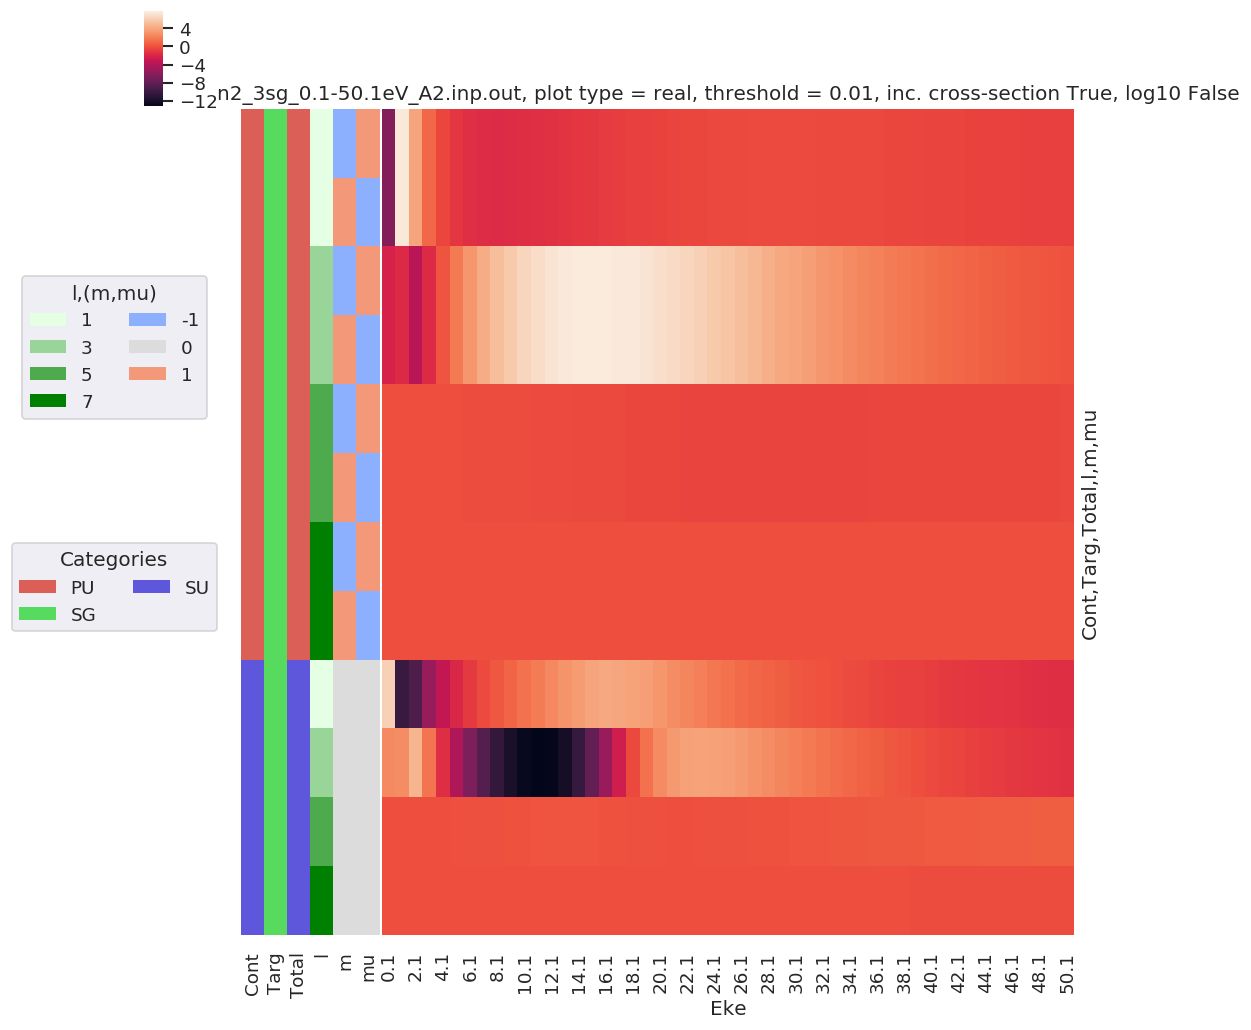

In [37]:
# Tabulate & plot matrix elements vs. Eke
selDims = {'it':1, 'Type':'L'}
matE = dataSet[0].sel(selDims)  # Set for N2 case, length-gauge results only.
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, xDim = 'Eke', pType = 'r', fillna = True)
daPlotpd

In [49]:
phaseConvention = 'E'  # Set phase conventions used in the numerics - for ePolyScat matrix elements, set to 'E', to match defns. above.

symSum = False  # Sum over symmetry groups, or keep separate?
SFflag = True  # Include scaling factor to Mb in calculation?
thres = 1e-4
RX = ep.setPolGeoms()  # Set default pol geoms (z,x,y), or will be set by mfblmXprod() defaults - FOR AF case this is only used to set 'z' geom for unity wigner D's - should rationalise this!

start = time.time()
mTermST, mTermS, mTermTest = ep.geomFunc.afblmXprod(dataSet[0], QNs = None, RX=RX, thres = thres, selDims = {'it':1, 'Type':'L'}, thresDims='Eke', symSum=symSum, SFflag=True, phaseConvention=phaseConvention)
end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points, {2} polarizations, threshold={3}.'.format((end-start), mTermST.Eke.size, RX.size, thres))

# Elapsed time = 3.3885273933410645 seconds, for 51 energy points, 3 polarizations, threshold=0.01.
# Elapsed time = 5.059587478637695 seconds, for 51 energy points, 3 polarizations, threshold=0.0001.

Elapsed time = 2.5987558364868164 seconds, for 51 energy points, 3 polarizations, threshold=0.0001.


Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


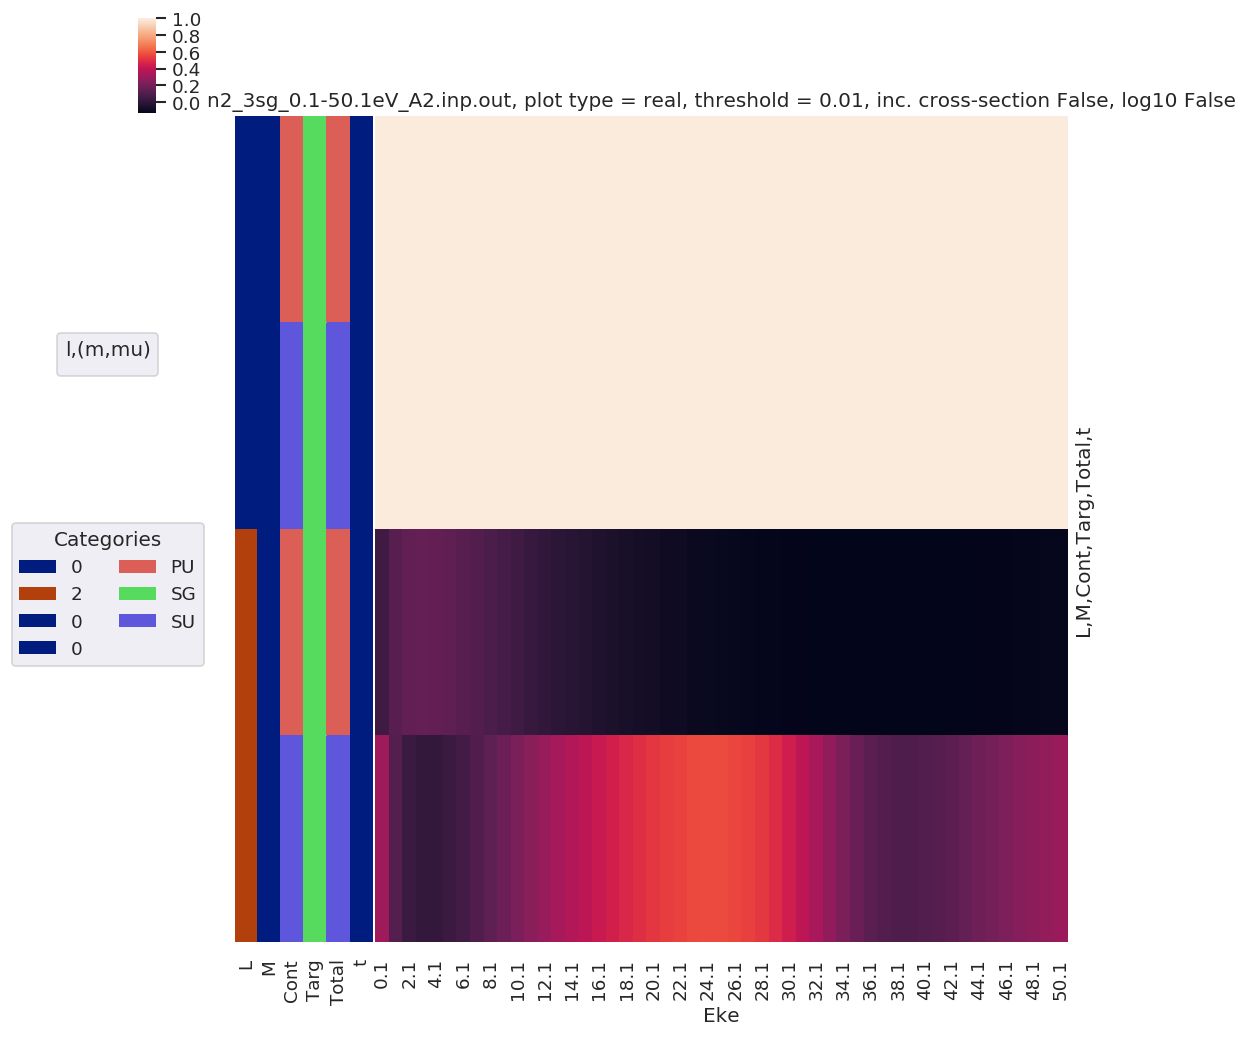

In [50]:
# Full results (before summation)
mTermST.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.

plotDimsRed = ['Labels','L','M']  # Set plotDims to fix dim ordering in plot
if not symSum:
    plotDimsRed.extend(['Cont','Targ','Total'])
    
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'r', thres = 0.01, fillna = True, SFflag=False)  

# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, xDim='Eke', sumDims=None, pType = 'r', thres = 0.01, fillna = True)  # If plotDims is not passed use default ordering.

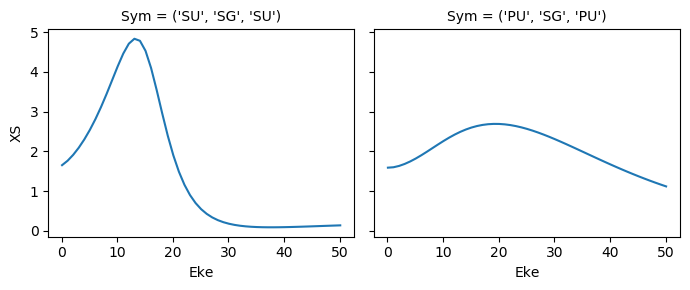

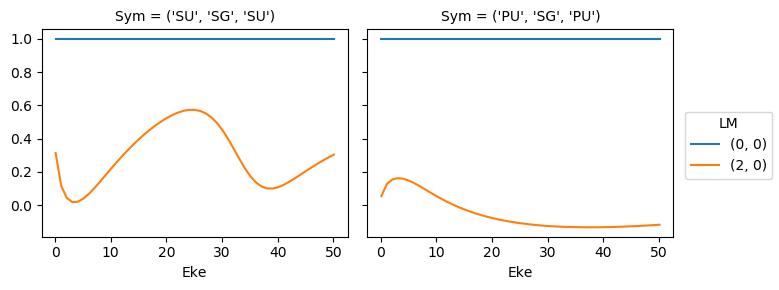

In [51]:
mTermST.XS.real.squeeze().plot.line(x='Eke', col='Sym');
ep.util.matEleSelector(mTermST, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke', col='Sym');

### Try sym summation...

In [60]:
phaseConvention = 'E'  # Set phase conventions used in the numerics - for ePolyScat matrix elements, set to 'E', to match defns. above.

symSum = True  # Sum over symmetry groups, or keep separate?
SFflag = False  # Include scaling factor to Mb in calculation?
thres = 1e-4
RX = ep.setPolGeoms()  # Set default pol geoms (z,x,y), or will be set by mfblmXprod() defaults - FOR AF case this is only used to set 'z' geom for unity wigner D's - should rationalise this!

start = time.time()
mTermST, mTermS, mTermTest = ep.geomFunc.afblmXprod(dataSet[0], QNs = None, RX=RX, thres = thres, selDims = {'it':1, 'Type':'L'}, thresDims='Eke', symSum=symSum, SFflag=True, phaseConvention=phaseConvention)
end = time.time()
print('Elapsed time = {0} seconds, for {1} energy points, {2} polarizations, threshold={3}.'.format((end-start), mTermST.Eke.size, RX.size, thres))

# Elapsed time = 3.3885273933410645 seconds, for 51 energy points, 3 polarizations, threshold=0.01.
# Elapsed time = 5.059587478637695 seconds, for 51 energy points, 3 polarizations, threshold=0.0001.

Elapsed time = 2.3066134452819824 seconds, for 51 energy points, 3 polarizations, threshold=0.0001.


Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


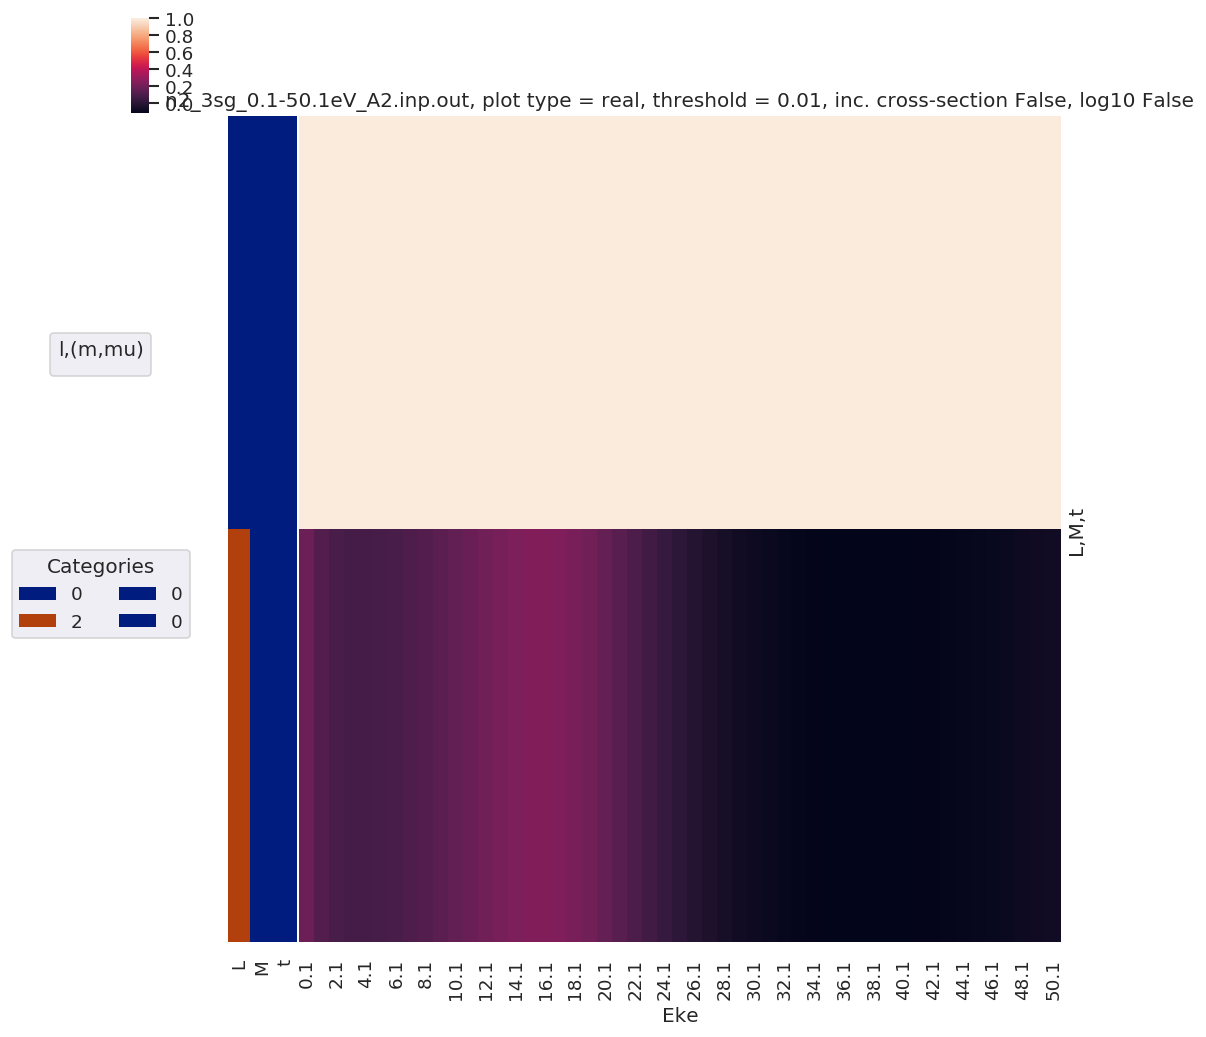

In [61]:
# Full results (before summation)
mTermST.attrs['dataType'] = 'matE'  # Set matE here to allow for correct plotting of sym dims.

plotDimsRed = ['Labels','L','M']  # Set plotDims to fix dim ordering in plot
if not symSum:
    plotDimsRed.extend(['Cont','Targ','Total'])
    
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, plotDims=plotDimsRed, xDim='Eke', sumDims=None, pType = 'r', thres = 0.01, fillna = True, SFflag=False)  

# daPlot, daPlotpd, legendList, gFig = ep.lmPlot(mTermST, xDim='Eke', sumDims=None, pType = 'r', thres = 0.01, fillna = True)  # If plotDims is not passed use default ordering.

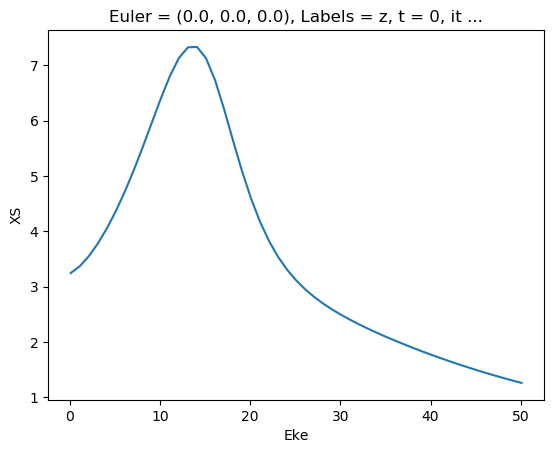

In [62]:
mTermST.XS.real.squeeze().plot.line(x='Eke');

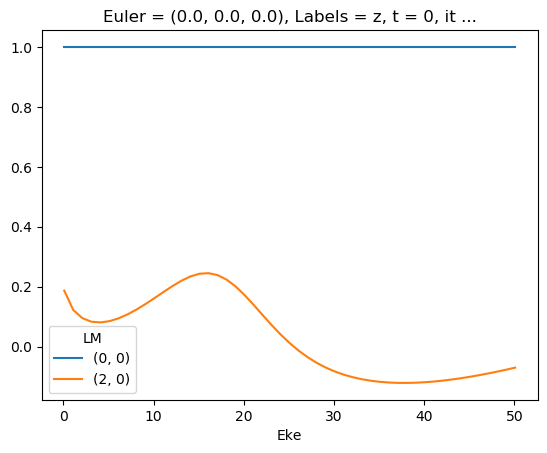

In [63]:
ep.util.matEleSelector(mTermST, thres = 0.1, dims='Eke').real.squeeze().plot.line(x='Eke');

First attempt... with sym summation

- Looks quite different - might be SF issue with combining continua, and/or degen factor...?

# SCRATCH

In [39]:
# Phase switch example
        if phaseCons['mfblmCons']['BLMmPhase']:
            QNsBLMtable[:,3] *= -1
            QNsBLMtable[:,5] *= -1

IndentationError: unexpected indent (<ipython-input-39-6783c300192b>, line 2)

In [ ]:

def deltaKQS(QNs = None):
    phaseCons = setPhaseConventions(phaseConvention = phaseConvention)

    # If no QNs are passed, set for all possible terms
    if QNs is None:
        QNs = []

        # Set photon terms
        l = 1
        lp = 1

        # Loop to set all other QNs
        for mu in np.arange(-l, l+1):
            for mup in np.arange(-lp, lp+1):
                #for R in np.arange(-(l+lp)-1, l+lp+2):
                #    for P in np.arange(0, l+lp+1):
                for P in np.arange(0, l+lp+1):
                    # for Rp in np.arange(-P, P+1):  # Allow all Rp
                    # Rp = -(mu+mup)   # Fix Rp terms - not valid here, depends on other phase cons!
                    # for R in np.arange(-P, P+1):
                    #     # QNs.append([l, lp, P, mu, -mup, R, Rp])
                    #     if phaseCons['lambdaCons']['negRp']:
                    #         Rp *= -1
                    #     if phaseCons['lambdaCons']['negMup']:
                    #         QNs.append([l, lp, P, mu, -mup, Rp, R])   # 31/03/20: FIXED bug, (R,Rp) previously misordered!!!
                    #     else:
                    #         QNs.append([l, lp, P, mu, mup, Rp, R])

                    # Rearranged for specified Rp case
                    for R in np.arange(-P, P+1):
                        # if phaseCons['lambdaCons']['negMup']:
                        #     mup = -mup

                        if phaseCons['lambdaCons']['negRp']:
                            # Rp = mu+mup
                            Rp = mup - mu
                        else:
                            Rp = -(mu+mup)

                        # Switch mup sign for 3j?  To match old numerics, this is *after* Rp assignment (sigh).
                        if phaseCons['lambdaCons']['negMup']:
                            mup = -mup

                        QNs.append([l, lp, P, mu, mup, Rp, R])

        QNs = np.array(QNs)